# MLP
MLP, K=5, epochs=200.
Use lncRNA.
Train set: filter middle.
Valid set: filter none.

In [13]:
from datetime import datetime
print(datetime.now())

2023-04-01 21:39:46.150709


In [14]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
# tf.random.set_seed(42) # supposedly leads to reproducible results

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/TrainTest_ver43/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/TrainTest_ver43/'    # Mac
print(DATA_DIR)

GPU device not found
Running on CoLab
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/


In [15]:
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
import scipy.stats as ss
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

from tensorflow import keras
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import matthews_corrcoef
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import AveragePooling1D
from keras.layers import MaxPooling1D
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=5
ALPHABET=4**K + 1
CFILTERS=64 
FILTERSIZE=8
RCELLS=32
DCELLS=16
EPOCHS=200 
EMBED_DIMEN = 4 # arbitrary hyperparameter
# MINLEN=200   # NO LONGER USED
MAXLEN=5000   
PRETTY_PICTURES = True
RCI_THRESHOLD_MECHANISM = 'ZERO'  # 'RCI_GMM' 'ZERO' 'THE_MEAN'
BREAK = False   # break after first fold
EXCLUSIONS = [1]   # possibly exclude cell line 1 = H1.hESC
FILTER_TRAIN        = True
FILTER_TAILS_TRAIN  = False
FILTER_MIDDLE_TRAIN = True
FILTER_TEST         = False
FILTER_TAILS_TEST   = False
FILTER_MIDDLE_TEST  = False

Python 3.9.16
sklearn 1.2.2


In [16]:
RCI_FILE_TRAIN = 'train.lncRNA_RCI.csv'
RCI_FILE_VALID = 'train.lncRNA_RCI.csv'
RCI_FILE_TEST  = None # else 'test.lncRNA_RCI.csv'

SEQ_FILE_TRAIN = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_VALID = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_TEST  = None # else 'test.canon_lncRNA_transcripts.csv'

In [17]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080',\
      'HUVEC','MCF.7','NCI.H460','NHEK','SK.MEL.5',\
      'SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()

## Data Load

In [18]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        self.gene2rci = dict()
        
    def load_gene_rci_values(self,filepath,exclusions):
        '''
        Load all the genes from the given RCI csv file.
        The given file usually contains train or test, not both.
        Load average RCI for each across cell lines.
        Define average as log of mean of antilogs: log2(mean(2^RCI)).
        Return dict with keys=gene:str and values=RCI:float.
        '''
        self.gene2rci = {}
        overall_sum = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    cell_line_index = 0
                    rci_values = []
                    log_mean=0.0
                    for rci_str in fields:
                        if cell_line_index not in exclusions:
                            if rci_str != "nan":
                                rci_val = float(rci_str)
                                rci_values.append(rci_val)
                        cell_line_index += 1
                    if len(rci_values)>0:
                        values = np.array(rci_values)
                        antilogs = [2**x for x in values]
                        big_mean = np.mean(antilogs)
                        if np.absolute(big_mean)<0.000001:
                            log_mean = -1000000 # neg infinity
                        else:
                            log_mean = np.log2(big_mean) 
                        self.gene2rci[gene_id] = log_mean
                    # TO DO: get rid of this check on our log/antilog arithmetic.
                    if len(rci_values)==1:
                        diff = rci_values[0]-log_mean
                        if diff>0.000001:
                            print('antilog',log_mean,'not equal',rci_values,'for gene',gene_id)
        print('Number of RCI values loaded',len(self.gene2rci.keys()))
        return self.gene2rci

    def _seq_to_kmer_values(self,rna,K):
        vec=[] # seq converted to list of K-mers 
        N_indicator = 0 # indicator value
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def load_sequence(self,filepath):
        '''
        Load all the sequences from the given file. 
        Load our version of GenCode -- csv, easier to parse than fasta.
        Each line has IDs plus sequence.
        The IDs in the file do not include dot-version numbers.
        The file may already be filtered e.g. canonical transcripts.
        '''
        allids=[]
        allseq=[]
        NREPEAT = str('N'*MAXLEN)
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # without version number
                    gene_id = fields[1]  # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    # Keep only transcripts having numeric RCI given the cell lines in use.
                    # We have validated this by spot checking.
                    # TO DO: validate this programmatically.
                    if gene_id in self.gene2rci.keys():
                        if seq_len<=MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                        seq_txt = seq_txt[:MAXLEN]
                        allids.append( (gene_id,tran_id) )
                        hot_vec = self._seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        self.cache=dict() # save RAM
        return allids,allseq

    def load_spectra(self,filepath):
        '''
        Load all (variable-length) sequences as lists of kmers.
        Then convert each sequence to (fixed-length) kmer histograms.
        '''
        allids,allseq = self.load_sequence(filepath)
        allspectra = []
        for seq in allseq:
            spectrum = np.zeros(ALPHABET)
            for kmer in seq:
                spectrum[kmer] += 1
            spectrum /= len(seq)
            allspectra.append(spectrum)
        return allids,allspectra        


## Model

In [19]:
def build_model():
    mlp    = Sequential()
    layer1 = Dense(64, activation='sigmoid',dtype=dt,input_dim=ALPHABET)
    layer2 = Dense(64, activation='sigmoid')
    layer3 = Dense(64, activation='sigmoid')
    output = Dense(1, activation='sigmoid')
    mlp.add(layer1)
    mlp.add(layer2)
    mlp.add(layer3)
    mlp.add(output)
      
    bc=BinaryCrossentropy(from_logits=False)
    mlp.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    return mlp

In [20]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once
model=None

2023-04-01 21:39:47.156971
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_44 (Dense)            (None, 64)                65664     
                                                                 
 dense_45 (Dense)            (None, 64)                4160      
                                                                 
 dense_46 (Dense)            (None, 64)                4160      
                                                                 
 dense_47 (Dense)            (None, 1)                 65        
                                                                 
Total params: 74,049
Trainable params: 74,049
Non-trainable params: 0
_________________________________________________________________
None


## Training

In [21]:
import gc
class CrossValidator():
    def __init__(self,epochs,quick_test=False,score_threshold=0.5):
        self.epochs = epochs
        self.quick_test = quick_test
        self.score_threshold = score_threshold
        self.mechanism = 'ZERO'
        self.discriminator = None
        self.flip = False
        self.reset_statistics()
        
    def reset_statistics(self):
        self.cv_accuracy=[]
        self.cv_precision=[]
        self.cv_recall=[]
        self.cv_f1=[]
        self.cv_auprc=[]
        self.cv_auroc=[]
        self.cv_mcc=[]
        
    def _get_X_y(self, all_ids, all_seqs, rci_map, exclude_middle=False): 
        # Prepare X and y for training or testing.
        subsetX=[]
        subsetY=[]
        for t in range(len(all_ids)):
            gene_id,tran_id = all_ids[t]
            oneX            = all_seqs[t]
            oneY            = rci_map[gene_id]
            if exclude_middle and oneY >= -2 and oneY <= 0:
                # Exclude middle from train set only, for comparison to Yuan et al
                continue
            subsetX.append(oneX)
            subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def set_threshold_mechanism(self, mechanism):
        if mechanism not in ['RCI_GMM','THE_MEAN','ZERO']:
            raise Exception('Unrecognized mechansm:',mechanism)
        self.mechanism = mechanism
    
    def _apply_threshold(self, array_of_rci):
        # Takes list of float, returns list of labels [0,1].
        if self.mechanism == 'RCI_GMM':
            labels = self.discriminator.predict(array_of_rci)
            if self.flip:
                IS_CYTO = lambda label: 1 if label==0 else 0
                labels = np.array(list(map(IS_CYTO, labels)))
        else:  # 'THE_MEAN' or 'ZERO'
            rci_threshold = self.discriminator
            IS_CYTO = lambda rci: 1 if rci>rci_threshold else 0
            labels = np.array(list(map(IS_CYTO, array_of_rci)))
        return labels
    
    def _prepare_threshold(self, rci_values, create=True):
        if self.mechanism == 'RCI_GMM':
            if create:  # during training, create a new GMM
                gmm = GaussianMixture(n_components=2, verbose=0, 
                  covariance_type='spherical', n_init=100) # random_state=42) 
                gmm.fit(rci_values)
            else:   # during testing, use existing GMM
                gmm=self.discriminator
            self.flip = False
            # The GMM labels are arbitrary.
            if gmm.means_[0][0] > gmm.means_[1][0]:
                self.flip = True
            self.discriminator = gmm   # redundant but consistent
        elif self.mechanism == 'THE_MEAN':
            self.discriminator = np.mean(rci_values)
        elif self.mechanism == 'ZERO':
            self.discriminator = -1   # 0 usually, -1 is as in Yuan et al.
        else: # not expected
            self.discriminator = 0
    
    def _explain_threshold(self):
        if self.mechanism == 'RCI_GMM':
            gmm=self.discriminator
            print('Discriminator is GMM')
            print('Means',[gmm.means_[0][0],gmm.means_[1][0]])
            print('Variances',gmm.covariances_)
            print('Priors',gmm.weights_)
            test_rcis=[-5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,3]
            print(test_rcis)
            print(self._apply_threshold(np.array(test_rcis).reshape((-1,1))))
        else:
            print('Discriminator',self.mechanism,self.discriminator)
    
    def _show_sizes(self,label,values):
        a = np.count_nonzero(values==1)
        b = np.count_nonzero(values==0)
        print('%s 1:0 %d:%d %5.2f%%'%(label,a,b,100*a/(a+b)))
        
    def save_model(self,filename):
        if self.model is not None:
            self.model.save(filename)
        
    def load_model(self,filename):
        self.model = keras.models.load_model(filename)
        
    def train_new_model(self,train_ids,train_seq,train_rci,
            valid_ids=None,valid_seq=None,valid_rci=None):
        print(datetime.now())
        X_train,y_rci = self._get_X_y(train_ids,train_seq,train_rci) 
        self._prepare_threshold(y_rci,True)  
        self._explain_threshold()
        y_train = self._apply_threshold(y_rci)
        self._show_sizes('Train',y_train)
        cw = class_weight.compute_class_weight(
            'balanced', classes=[0,1], y=y_train)
        cwd = {0: cw[0], 1: cw[1]}
        print('Computed class weights:',cwd)
        if valid_ids is not None:
            X_valid,y_rci = self._get_X_y(valid_ids,valid_seq,valid_rci) 
            y_valid = self._apply_threshold(y_rci)
            self._show_sizes('Valid',y_valid)
        y_rci = None

        self.model=build_model()
        print("FIT")
        print(datetime.now())
        if valid_ids is None:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd) # no validation
        else:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd, 
            validation_data=(X_valid,y_valid) ) 

        if PRETTY_PICTURES:
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()
        
    def test_without_training(self,test_ids,test_seq,test_rci):
        # For final test, do no train.
        # Assume set_sequences() set the test set.
        print(datetime.now())
        X_test,y_rci = self._get_X_y(test_ids,test_seq,test_rci) 
        y_test = self._apply_threshold(y_rci)
        y_rci = None
        
        print("PREDICT")
        print(datetime.now())        
        yhat_pred=self.model.predict(X_test, verbose=0)     
        yhat_classes=np.where(yhat_pred > self.score_threshold, 1, 0)

        self._show_sizes('Test',y_test)
        self._show_sizes('Predict',yhat_classes)
        print('Test sizes',X_test.shape,y_test.shape)
        print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
        print('Score threshold',self.score_threshold)
        cm1 = confusion_matrix(y_test,yhat_classes)
        print('Confusion matrix\n',cm1)
        cm2 = confusion_matrix(y_test,yhat_classes,normalize='all')
        print('Normalized matrix\n',cm2)

        accuracy = accuracy_score(y_test, yhat_classes)*100.
        precision = precision_score(y_test, yhat_classes)*100.
        recall = recall_score(y_test, yhat_classes)*100.
        f1 = f1_score(y_test, yhat_classes)*100.
        prc_Y, prc_X, prc_bins = precision_recall_curve(y_test, yhat_pred)
        auprc = auc(prc_X,prc_Y)*100.
        auroc = roc_auc_score(y_test, yhat_pred)*100.
        mcc = matthews_corrcoef(y_test, yhat_classes)
        if PRETTY_PICTURES:
            self._pretty_pictures(y_test,yhat_pred,prc_X,prc_Y)
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%%' % (accuracy,precision,recall)) 
            print('F1: %.2f%% MCC: %.4f' % (f1,mcc)) 
            print('AUPRC: %.2f%% AUROC: %.2f%%' % (auprc,auroc)) 
        self.cv_accuracy.append(accuracy)
        self.cv_precision.append(precision)
        self.cv_recall.append(recall)
        self.cv_f1.append(f1)
        self.cv_mcc.append(mcc)
        self.cv_auprc.append(auprc)
        self.cv_auroc.append(auroc)

    def _pretty_pictures(self,y_valid,yhat_pred,prc_X,prc_Y):
        count_ones= len(y_valid[y_valid==1])
        count_zeros= len(y_valid[y_valid==0])
        guess = max(count_ones,count_zeros) / len(y_valid)
        # PRC
        plt.plot(prc_X, prc_Y, marker='.')
        plt.plot([0, 1], [guess,guess], linestyle='--')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.show()
        # ROC
        fpr, tpr, roc_bins = roc_curve(y_valid, yhat_pred)
        plt.plot(fpr, tpr, marker='.')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()
        
    def get_statistics(self):
        return \
        self.cv_accuracy,\
        self.cv_precision,\
        self.cv_recall,\
        self.cv_f1,\
        self.cv_mcc,\
        self.cv_auprc,\
        self.cv_auroc


## Train

In [22]:
class Separator():
    def __init__(self):
        self.train_ids = []
        self.train_seq = []
        self.train_rci = dict()
        self.val_ids = []
        self.val_seq = []
        self.val_rci = dict()
    def load(self,data_dir,rep,fold):
        filename='cv.{}.{}.validation_genes.txt'.format(rep,fold)
        filename = data_dir + filename
        self.val_genes = set()
        with open(filename,'r') as fin:
            for line in fin:
                gene_id = line.strip()
                self.val_genes.add(gene_id)
    def process(self,allids,allseq,gene_to_rci):
        size = len(allids)
        for t in range(size):
            gene_id,tran_id = allids[t]
            oneX            = allseq[t]
            oneY            = gene_to_rci[gene_id]
            in_middle = gene_to_rci[gene_id] >= -2 and gene_to_rci[gene_id] <= 0
            in_tails = gene_to_rci[gene_id] < -2 or gene_to_rci[gene_id] > 0
            if gene_id in self.val_genes:
                if not FILTER_TEST or \
                    (FILTER_TAILS_TEST and in_middle) or \
                    (FILTER_MIDDLE_TEST and in_tails):
                    self.val_ids.append(allids[t])
                    self.val_seq.append(allseq[t])
                    self.val_rci[gene_id]=gene_to_rci[gene_id]
            else:
                if not FILTER_TRAIN or \
                    (FILTER_TAILS_TRAIN and in_middle) or \
                    (FILTER_MIDDLE_TRAIN and in_tails):
                    self.train_ids.append(allids[t])
                    self.train_seq.append(allseq[t])
                    self.train_rci[gene_id]=gene_to_rci[gene_id]
    def get_ids(self):
        return self.train_ids,self.val_ids
    def get_seq(self):
        return self.train_seq,self.val_seq
    def get_rci(self):
        return self.train_rci,self.val_rci

2023-04-01 21:39:47.334180
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.csv
Number of RCI values loaded 4369
Num RCI: 4369
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.canon_lncRNA_transcripts.csv
Loaded 4369 sequences.
2023-04-01 21:40:05.329754

Training # 1 1
2023-04-01 21:40:05.331057
2023-04-01 21:40:05.331308
Discriminator ZERO -1
Train 1:0 1043:1031 50.29%
Computed class weights: {0: 1.005819592628516, 1: 0.9942473633748802}
Valid 1:0 458:412 52.64%
FIT
2023-04-01 21:40:05.397431


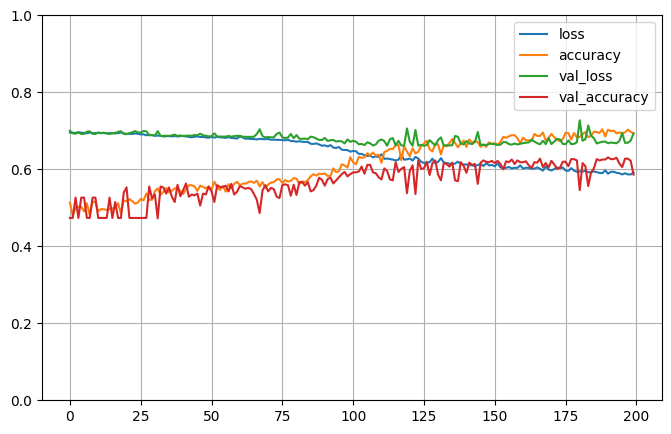


2023-04-01 21:41:28.508780

Testing # 1 1
2023-04-01 21:41:28.508910
2023-04-01 21:41:28.508956
PREDICT
2023-04-01 21:41:28.515947
Test 1:0 458:412 52.64%
Predict 1:0 286:584 32.87%
Test sizes (870, 1025) (870,)
Range of scores: 0.0028038933 to 0.9661153
Score threshold 0.5
Confusion matrix
 [[318  94]
 [266 192]]
Normalized matrix
 [[0.36551724 0.10804598]
 [0.30574713 0.22068966]]


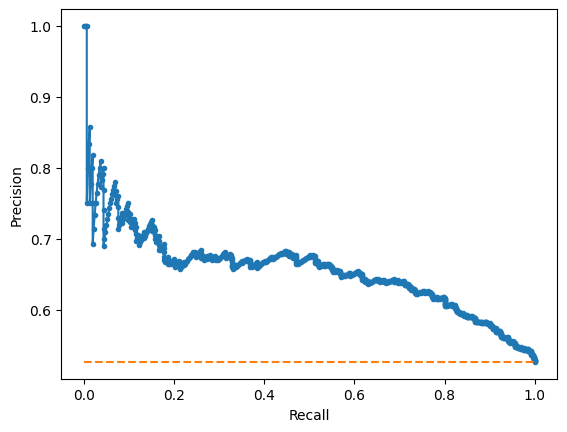

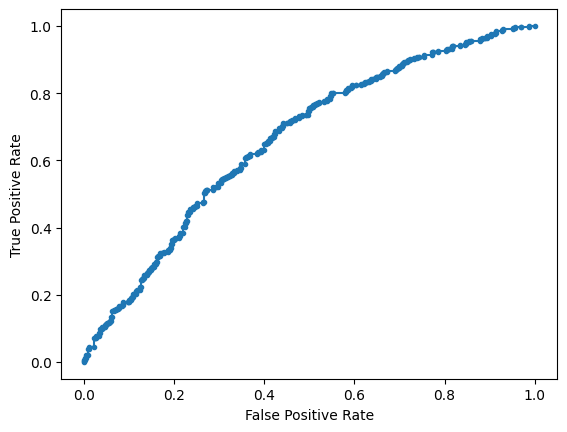

Accuracy: 58.62% Precision: 67.13% Recall: 41.92%
F1: 51.61% MCC: 0.2031
AUPRC: 65.57% AUROC: 66.17%
 accuracy [58.620689655172406]
 precision [67.13286713286713]
 recall [41.92139737991266]
 F1 [51.61290322580645]
 MCC [0.20307598819896822]
 AUPRC [65.57025869961687]
 AUROC [66.16727434603807]
2023-04-01 21:41:29.100838

Training # 1 2
2023-04-01 21:41:29.102070
2023-04-01 21:41:29.102133
Discriminator ZERO -1
Train 1:0 1074:1030 51.05%
Computed class weights: {0: 1.021359223300971, 1: 0.9795158286778398}
Valid 1:0 442:442 50.00%
FIT
2023-04-01 21:41:29.180642


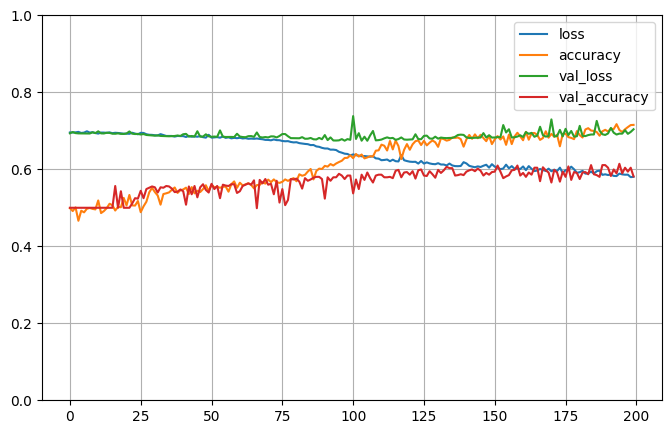


2023-04-01 21:42:22.973270

Testing # 1 2
2023-04-01 21:42:22.973433
2023-04-01 21:42:22.973486
PREDICT
2023-04-01 21:42:22.990083
Test 1:0 442:442 50.00%
Predict 1:0 294:590 33.26%
Test sizes (884, 1025) (884,)
Range of scores: 0.0052029323 to 0.9904982
Score threshold 0.5
Confusion matrix
 [[331 111]
 [259 183]]
Normalized matrix
 [[0.37443439 0.12556561]
 [0.29298643 0.20701357]]


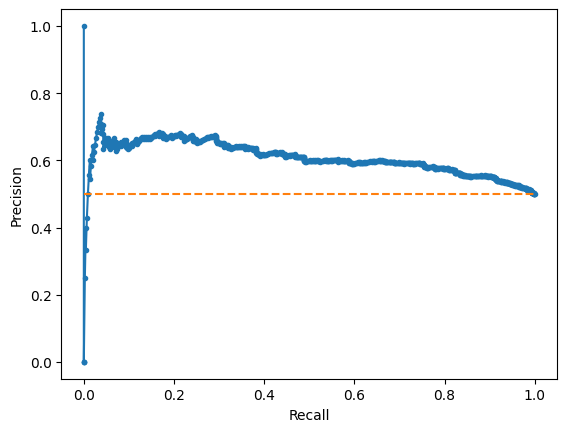

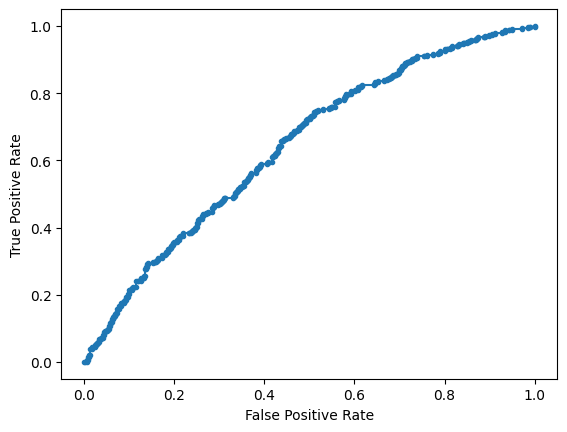

Accuracy: 58.14% Precision: 62.24% Recall: 41.40%
F1: 49.73% MCC: 0.1729
AUPRC: 60.67% AUROC: 64.21%
 accuracy [58.144796380090504]
 precision [62.244897959183675]
 recall [41.40271493212669]
 F1 [49.72826086956522]
 MCC [0.17287525168786652]
 AUPRC [60.67289963033882]
 AUROC [64.21295632767551]
2023-04-01 21:42:23.576226

Training # 1 3
2023-04-01 21:42:23.577482
2023-04-01 21:42:23.577568
Discriminator ZERO -1
Train 1:0 1066:1034 50.76%
Computed class weights: {0: 1.0154738878143132, 1: 0.9849906191369606}
Valid 1:0 442:407 52.06%
FIT
2023-04-01 21:42:23.641583


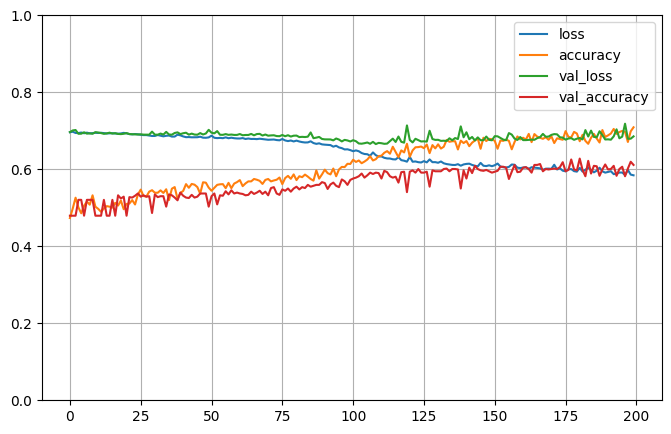


2023-04-01 21:43:46.895212

Testing # 1 3
2023-04-01 21:43:46.896840
2023-04-01 21:43:46.897221
PREDICT
2023-04-01 21:43:46.905165
Test 1:0 442:407 52.06%
Predict 1:0 340:509 40.05%
Test sizes (849, 1025) (849,)
Range of scores: 0.012078945 to 0.9882381
Score threshold 0.5
Confusion matrix
 [[293 114]
 [216 226]]
Normalized matrix
 [[0.3451119  0.13427562]
 [0.25441696 0.26619552]]


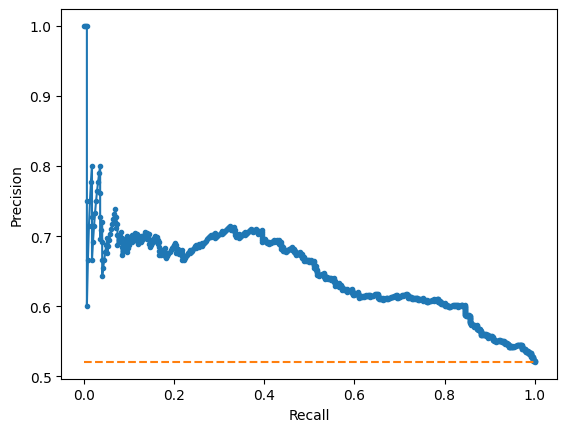

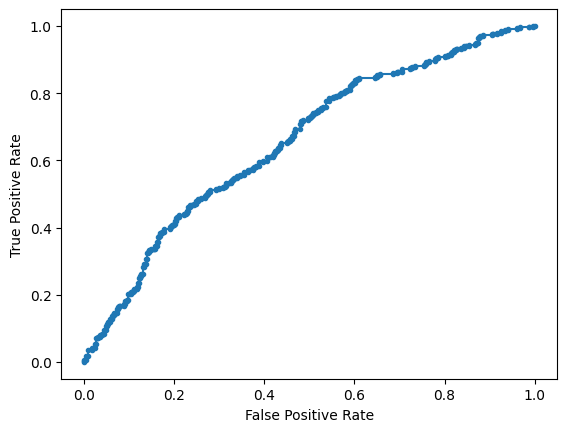

Accuracy: 61.13% Precision: 66.47% Recall: 51.13%
F1: 57.80% MCC: 0.2357
AUPRC: 64.81% AUROC: 65.59%
 accuracy [61.130742049469966]
 precision [66.47058823529412]
 recall [51.13122171945701]
 F1 [57.800511508951416]
 MCC [0.23573496238928865]
 AUPRC [64.81372224398288]
 AUROC [65.58695676342735]
2023-04-01 21:43:47.804701

Training # 1 4
2023-04-01 21:43:47.807038
2023-04-01 21:43:47.807534
Discriminator ZERO -1
Train 1:0 1055:1041 50.33%
Computed class weights: {0: 1.0067243035542748, 1: 0.9933649289099526}
Valid 1:0 459:431 51.57%
FIT
2023-04-01 21:43:47.923132


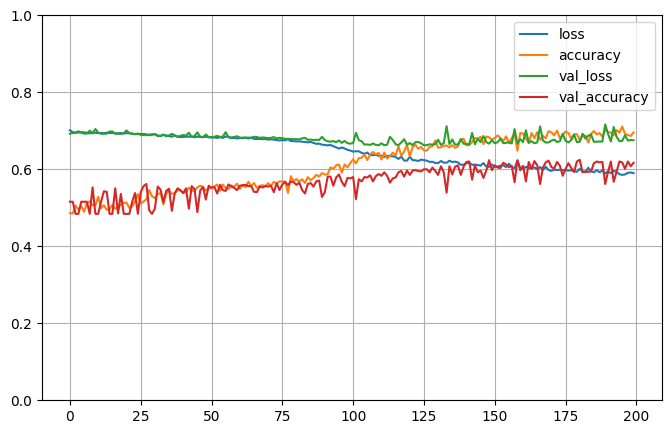


2023-04-01 21:45:11.518561

Testing # 1 4
2023-04-01 21:45:11.520284
2023-04-01 21:45:11.520712
PREDICT
2023-04-01 21:45:11.532843
Test 1:0 459:431 51.57%
Predict 1:0 568:322 63.82%
Test sizes (890, 1025) (890,)
Range of scores: 0.004510598 to 0.97379
Score threshold 0.5
Confusion matrix
 [[206 225]
 [116 343]]
Normalized matrix
 [[0.23146067 0.25280899]
 [0.13033708 0.38539326]]


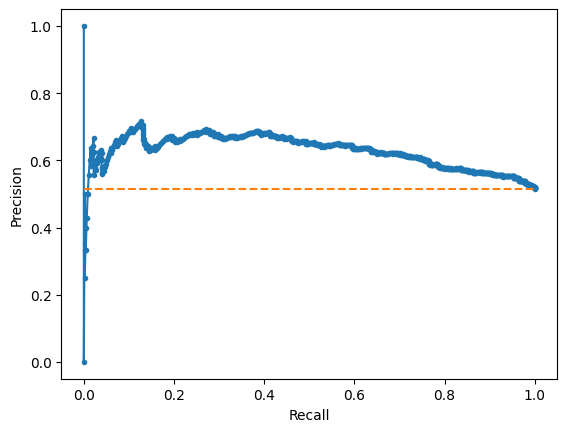

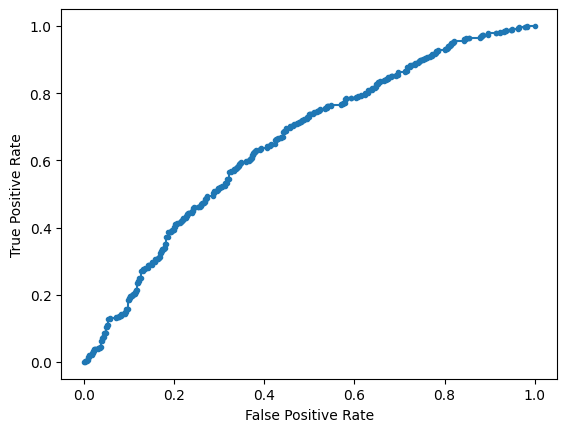

Accuracy: 61.69% Precision: 60.39% Recall: 74.73%
F1: 66.80% MCC: 0.2342
AUPRC: 62.69% AUROC: 65.42%
 accuracy [61.68539325842697]
 precision [60.387323943661976]
 recall [74.7276688453159]
 F1 [66.79649464459591]
 MCC [0.23424946495935645]
 AUPRC [62.687874264355095]
 AUROC [65.42013557163004]
2023-04-01 21:45:12.413470

Training # 1 5
2023-04-01 21:45:12.415543
2023-04-01 21:45:12.416016
Discriminator ZERO -1
Train 1:0 1054:1036 50.43%
Computed class weights: {0: 1.0086872586872586, 1: 0.99146110056926}
Valid 1:0 457:419 52.17%
FIT
2023-04-01 21:45:12.491737


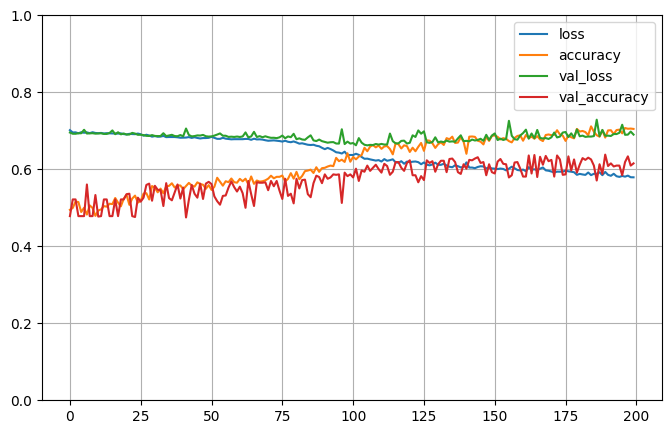


2023-04-01 21:46:36.041023

Testing # 1 5
2023-04-01 21:46:36.041153
2023-04-01 21:46:36.041198
PREDICT
2023-04-01 21:46:36.052135
Test 1:0 457:419 52.17%
Predict 1:0 540:336 61.64%
Test sizes (876, 1025) (876,)
Range of scores: 0.0017714343 to 0.9847324
Score threshold 0.5
Confusion matrix
 [[209 210]
 [127 330]]
Normalized matrix
 [[0.23858447 0.23972603]
 [0.14497717 0.37671233]]


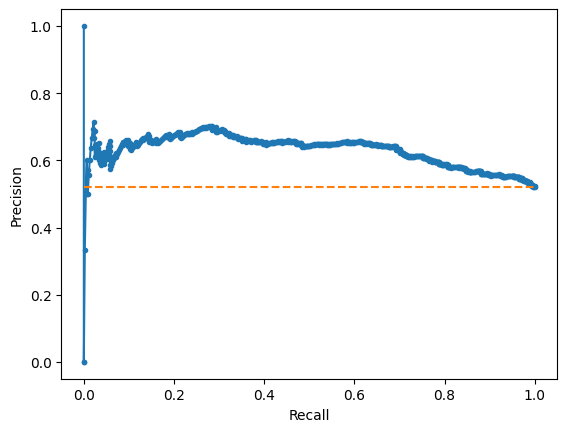

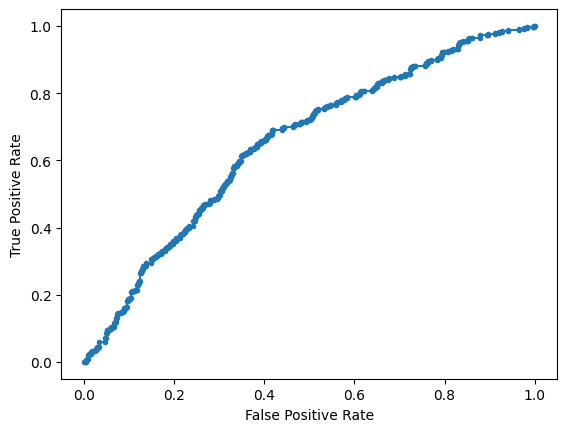

Accuracy: 61.53% Precision: 61.11% Recall: 72.21%
F1: 66.20% MCC: 0.2269
AUPRC: 62.94% AUROC: 65.06%
 accuracy [61.5296803652968]
 precision [61.111111111111114]
 recall [72.21006564551422]
 F1 [66.1985957873621]
 MCC [0.22693879120384391]
 AUPRC [62.939816399252656]
 AUROC [65.06217262106819]
2023-04-01 21:46:36.665736

Training # 2 1
2023-04-01 21:46:36.665921
2023-04-01 21:46:36.665975
Discriminator ZERO -1
Train 1:0 1049:1035 50.34%
Computed class weights: {0: 1.0067632850241546, 1: 0.9933269780743565}
Valid 1:0 472:415 53.21%
FIT
2023-04-01 21:46:36.737445


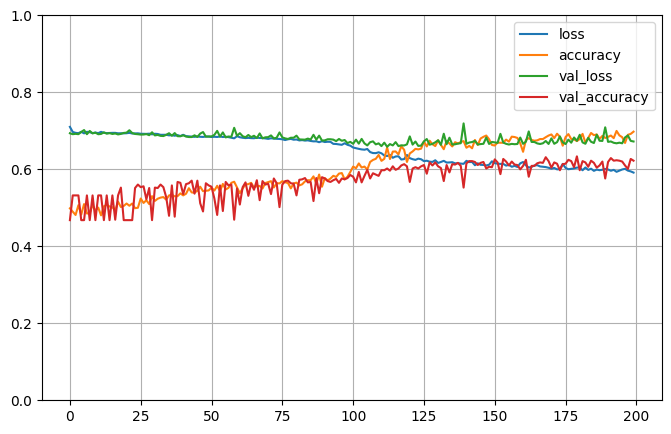


2023-04-01 21:47:29.723951

Testing # 2 1
2023-04-01 21:47:29.724072
2023-04-01 21:47:29.724117
PREDICT
2023-04-01 21:47:29.737304
Test 1:0 472:415 53.21%
Predict 1:0 421:466 47.46%
Test sizes (887, 1025) (887,)
Range of scores: 0.014154569 to 0.98336536
Score threshold 0.5
Confusion matrix
 [[273 142]
 [193 279]]
Normalized matrix
 [[0.30777903 0.16009019]
 [0.21758737 0.3145434 ]]


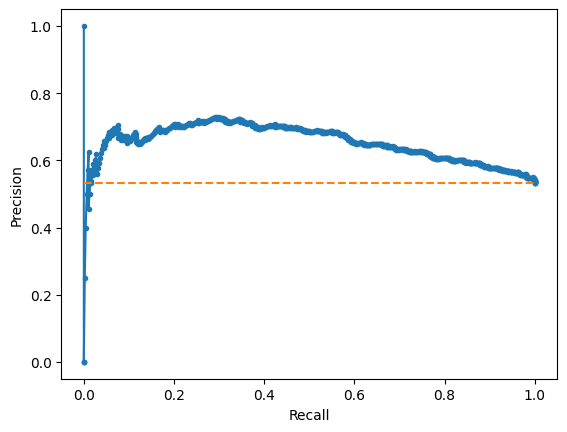

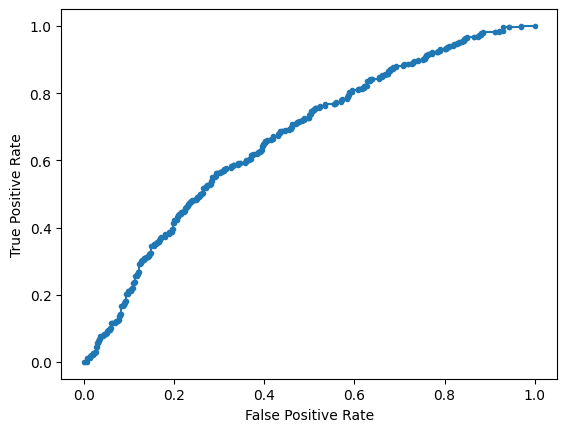

Accuracy: 62.23% Precision: 66.27% Recall: 59.11%
F1: 62.49% MCC: 0.2487
AUPRC: 65.16% AUROC: 66.66%
 accuracy [62.232243517474636]
 precision [66.270783847981]
 recall [59.11016949152542]
 F1 [62.48600223964166]
 MCC [0.24873880852405764]
 AUPRC [65.15594767378698]
 AUROC [66.66122115580968]
2023-04-01 21:47:30.387947

Training # 2 2
2023-04-01 21:47:30.390139
2023-04-01 21:47:30.390215
Discriminator ZERO -1
Train 1:0 1062:1030 50.76%
Computed class weights: {0: 1.0155339805825243, 1: 0.9849340866290018}
Valid 1:0 452:416 52.07%
FIT
2023-04-01 21:47:30.455601


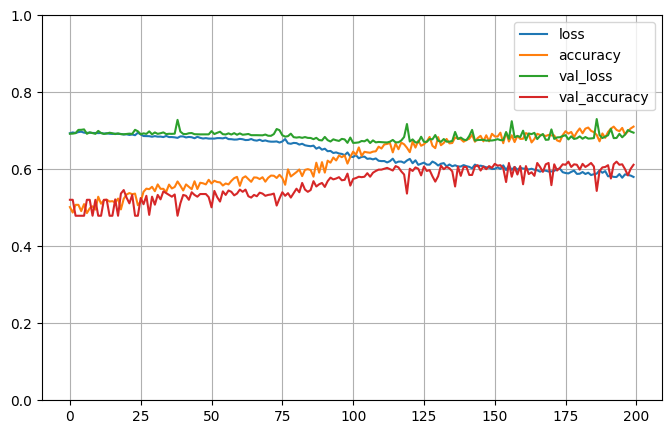


2023-04-01 21:48:23.205817

Testing # 2 2
2023-04-01 21:48:23.205938
2023-04-01 21:48:23.205981
PREDICT
2023-04-01 21:48:23.215869
Test 1:0 452:416 52.07%
Predict 1:0 349:519 40.21%
Test sizes (868, 1025) (868,)
Range of scores: 0.004945789 to 0.9820819
Score threshold 0.5
Confusion matrix
 [[299 117]
 [220 232]]
Normalized matrix
 [[0.34447005 0.13479263]
 [0.25345622 0.26728111]]


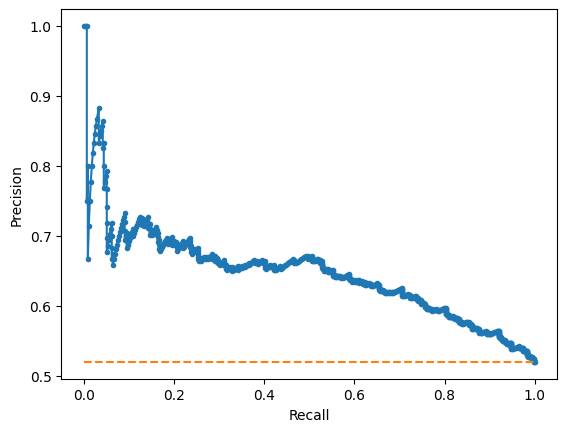

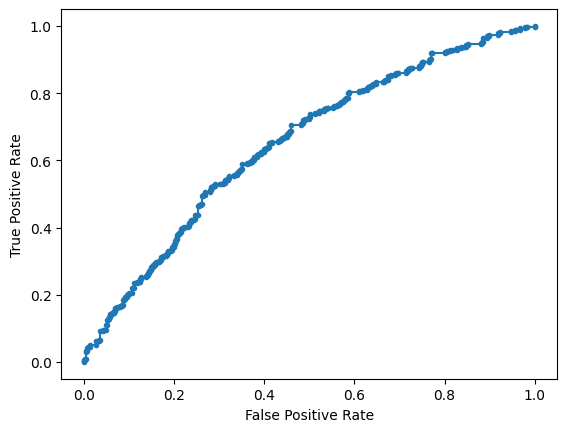

Accuracy: 61.18% Precision: 66.48% Recall: 51.33%
F1: 57.93% MCC: 0.2364
AUPRC: 64.70% AUROC: 65.05%
 accuracy [61.175115207373274]
 precision [66.4756446991404]
 recall [51.32743362831859]
 F1 [57.92759051186018]
 MCC [0.23640302493889]
 AUPRC [64.69983215443375]
 AUROC [65.05062968005446]
2023-04-01 21:48:23.802677

Training # 2 3
2023-04-01 21:48:23.803900
2023-04-01 21:48:23.804152
Discriminator ZERO -1
Train 1:0 1047:1051 49.90%
Computed class weights: {0: 0.9980970504281637, 1: 1.0019102196752627}
Valid 1:0 453:407 52.67%
FIT
2023-04-01 21:48:23.866827


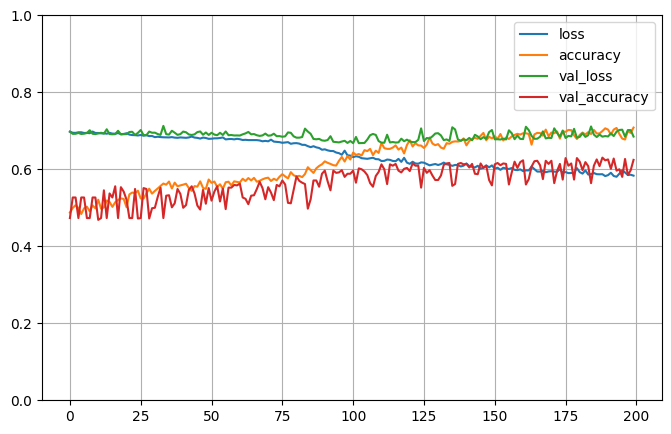


2023-04-01 21:49:17.272007

Testing # 2 3
2023-04-01 21:49:17.273762
2023-04-01 21:49:17.274158
PREDICT
2023-04-01 21:49:17.286007
Test 1:0 453:407 52.67%
Predict 1:0 514:346 59.77%
Test sizes (860, 1025) (860,)
Range of scores: 0.003552536 to 0.9855193
Score threshold 0.5
Confusion matrix
 [[215 192]
 [131 322]]
Normalized matrix
 [[0.25       0.22325581]
 [0.15232558 0.3744186 ]]


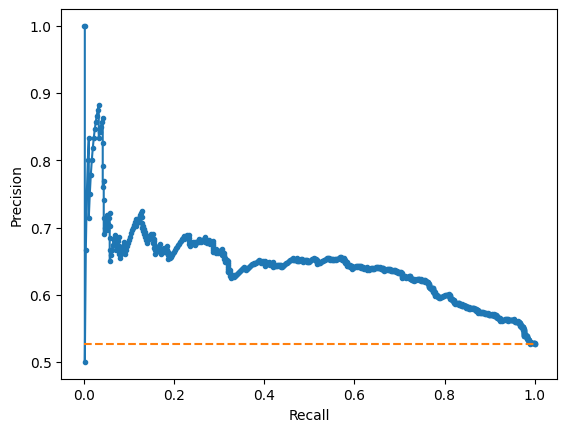

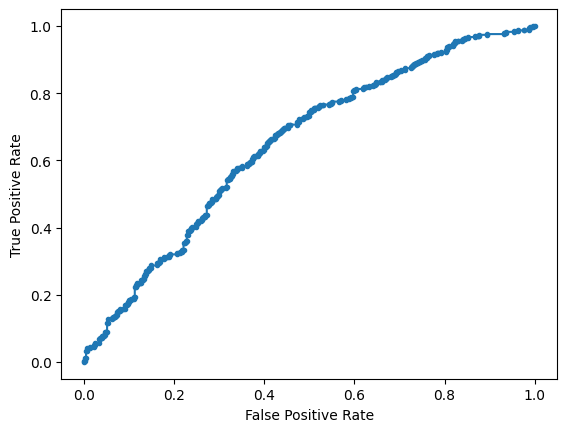

Accuracy: 62.44% Precision: 62.65% Recall: 71.08%
F1: 66.60% MCC: 0.2434
AUPRC: 64.32% AUROC: 64.88%
 accuracy [62.441860465116285]
 precision [62.64591439688716]
 recall [71.08167770419426]
 F1 [66.59772492244052]
 MCC [0.24341983631546577]
 AUPRC [64.32326907787478]
 AUROC [64.8781532887493]
2023-04-01 21:49:18.183720

Training # 2 4
2023-04-01 21:49:18.185585
2023-04-01 21:49:18.186001
Discriminator ZERO -1
Train 1:0 1068:1024 51.05%
Computed class weights: {0: 1.021484375, 1: 0.9794007490636704}
Valid 1:0 432:447 49.15%
FIT
2023-04-01 21:49:18.289461


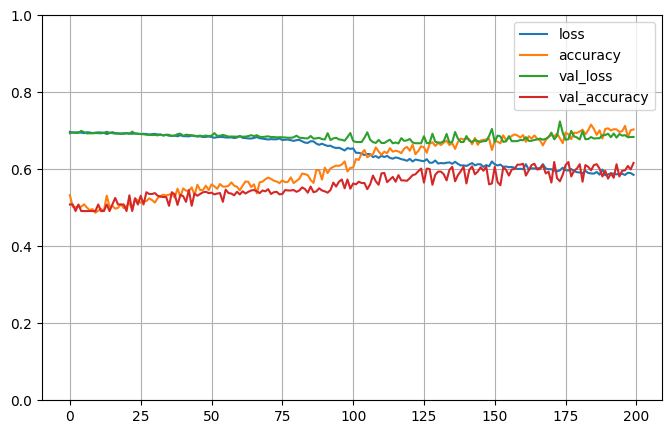


2023-04-01 21:50:41.857587

Testing # 2 4
2023-04-01 21:50:41.857699
2023-04-01 21:50:41.857736
PREDICT
2023-04-01 21:50:41.868756
Test 1:0 432:447 49.15%
Predict 1:0 413:466 46.99%
Test sizes (879, 1025) (879,)
Range of scores: 0.0012422635 to 0.9603193
Score threshold 0.5
Confusion matrix
 [[288 159]
 [178 254]]
Normalized matrix
 [[0.32764505 0.18088737]
 [0.20250284 0.28896473]]


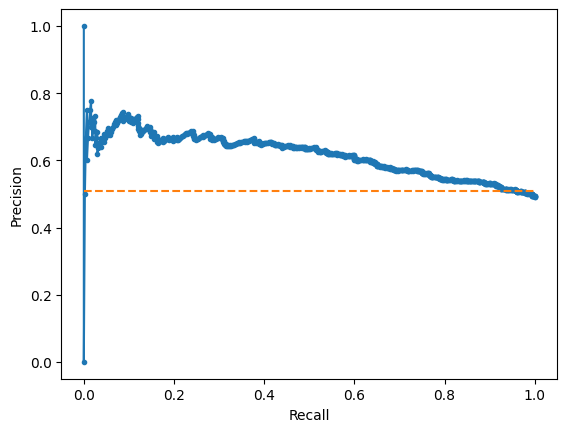

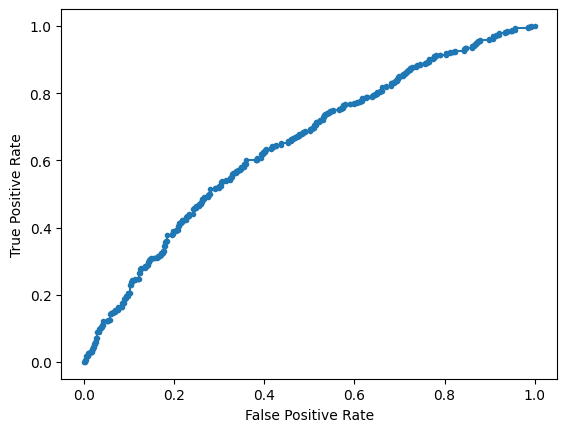

Accuracy: 61.66% Precision: 61.50% Recall: 58.80%
F1: 60.12% MCC: 0.2326
AUPRC: 61.57% AUROC: 64.58%
 accuracy [61.66097838452787]
 precision [61.50121065375303]
 recall [58.79629629629629]
 F1 [60.11834319526626]
 MCC [0.23264773474596057]
 AUPRC [61.57431344109501]
 AUROC [64.58126191068025]
2023-04-01 21:50:42.480874

Training # 2 5
2023-04-01 21:50:42.483219
2023-04-01 21:50:42.483727
Discriminator ZERO -1
Train 1:0 1066:1032 50.81%
Computed class weights: {0: 1.0164728682170543, 1: 0.9840525328330206}
Valid 1:0 449:426 51.31%
FIT
2023-04-01 21:50:42.549708


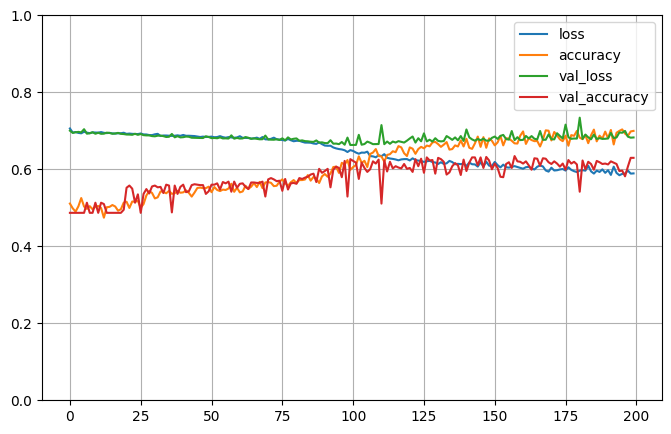


2023-04-01 21:51:35.988235

Testing # 2 5
2023-04-01 21:51:35.988369
2023-04-01 21:51:35.988414
PREDICT
2023-04-01 21:51:35.998122
Test 1:0 449:426 51.31%
Predict 1:0 545:330 62.29%
Test sizes (875, 1025) (875,)
Range of scores: 0.0062340233 to 0.9921094
Score threshold 0.5
Confusion matrix
 [[216 210]
 [114 335]]
Normalized matrix
 [[0.24685714 0.24      ]
 [0.13028571 0.38285714]]


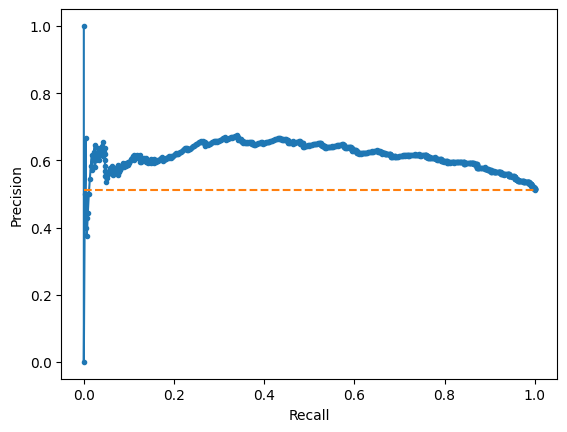

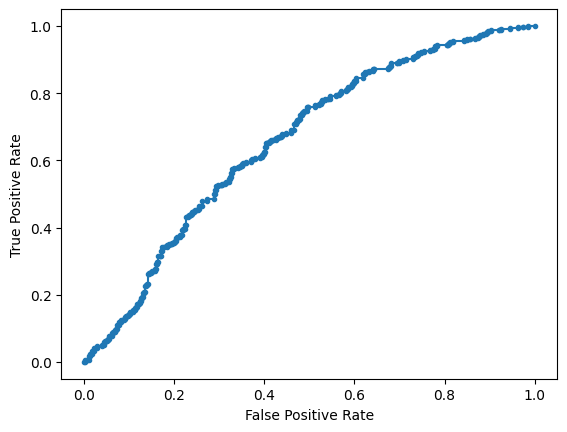

Accuracy: 62.97% Precision: 61.47% Recall: 74.61%
F1: 67.40% MCC: 0.2611
AUPRC: 61.41% AUROC: 65.71%
 accuracy [62.97142857142857]
 precision [61.46788990825688]
 recall [74.61024498886414]
 F1 [67.40442655935614]
 MCC [0.26106075758308167]
 AUPRC [61.409065015907416]
 AUROC [65.71149241402387]
2023-04-01 21:51:36.567176


In [23]:
print(datetime.now())

accuracy=[]
precision=[]
recall=[]
f1=[]
mcc=[]
auprc=[]
auroc=[]

loader = DataLoader()
filepath = DATA_DIR+RCI_FILE_TRAIN
print("Load RCI from",filepath)
gene_to_rci = loader.load_gene_rci_values(filepath,EXCLUSIONS)
print('Num RCI:', len(gene_to_rci.keys()))
filepath = DATA_DIR+SEQ_FILE_TRAIN
print('Load sequence from',filepath)
allids,allseq = loader.load_spectra(filepath)
print('Loaded',len(allseq),'sequences.')
test_gene_to_rci = None
test_allids = None
test_allseq = None
if SEQ_FILE_TEST is not None:
    # Train on the entire train set (no cross-validation).
    # Evaluate with the test files.
    test_loader = DataLoader()
    filepath = DATA_DIR+RCI_FILE_TEST
    print("Load RCI from",filepath)
    test_gene_to_rci = test_loader.load_gene_rci_values(filepath,EXCLUSIONS)
    print('Num RCI:', len(test_gene_to_rci.keys()))
    filepath = DATA_DIR+SEQ_FILE_TEST
    print('Load sequence from',filepath)
    test_allids,test_allseq = test_loader.load_spectra(filepath)
    print('Loaded',len(test_allseq),'sequences.')

REPEATS = 2
FOLDS = 5
for repeat in range(REPEATS):
    for fold in range(FOLDS):
        r = repeat+1
        f = fold+1

        if SEQ_FILE_TEST is None:
            # Train on 80% and evaluate on 20%.
            separator = Separator()
            separator.load(DATA_DIR,r,f)
            separator.process(allids,allseq,gene_to_rci)
            train_allids,test_allids = separator.get_ids()
            train_allseq,test_allseq = separator.get_seq()
            train_gene_to_rci,test_gene_to_rci = separator.get_rci()
        else:
            # Train on the entire train set (no cross-validation).
            # Evaluate with the test files.
            train_allids = allids
            train_allseq = allseq
            train_gene_to_rci = gene_to_rci
            test_allids = None
            test_allseq = None
            test_gene_to_rci = None
            
        print(datetime.now())
        print()
        print("Training #",r,f)
        print(datetime.now())
        cvdo = CrossValidator(EPOCHS,BREAK)
        cvdo.set_threshold_mechanism(RCI_THRESHOLD_MECHANISM)
        cvdo.train_new_model(
            train_allids,train_allseq,train_gene_to_rci,
            test_allids,test_allseq,test_gene_to_rci)
           
        print()
        print(datetime.now())
        print()
        print("Testing #",r,f)
        print(datetime.now())
        cvdo.reset_statistics()
        cvdo.test_without_training(
            test_allids,test_allseq,test_gene_to_rci)
        cv_accuracy,cv_precision,cv_recall,cv_f1,cv_mcc,cv_auprc,cv_auroc=\
            cvdo.get_statistics()

        print(" accuracy" ,  cv_accuracy)
        print(" precision" , cv_precision)
        print(" recall" ,    cv_recall)
        print(" F1" ,        cv_f1)
        print(" MCC" ,       cv_mcc)
        print(" AUPRC" ,     cv_auprc)
        print(" AUROC" ,     cv_auroc)

        accuracy.append(cv_accuracy)
        precision.append(cv_precision)
        recall.append(cv_recall)
        f1.append(cv_f1)
        mcc.append(cv_mcc)
        auprc.append(cv_auprc)
        auroc.append(cv_auroc)
        if BREAK: break
    if BREAK: break
print(datetime.now())

In [24]:
def STD (values):
    return np.std(values,ddof=1)

print(" accuracy mean %.2f%% std %.2f" %  (np.mean(accuracy),  STD(accuracy)))
print(" precision mean %.2f%% std %.2f" % (np.mean(precision), STD(precision)))
print(" recall mean %.2f%% std %.2f" %    (np.mean(recall),    STD(recall)))
print(" F1 mean %.2f%% std %.2f" %        (np.mean(f1),        STD(f1)))
print(" MCC mean %.2f%% std %.2f" %       (np.mean(mcc),       STD(mcc)))
print(" AUPRC mean %.2f%% std %.2f" %     (np.mean(auprc),     STD(auprc)))
print(" AUROC mean %.2f%% std %.2f" %     (np.mean(auroc),     STD(auroc)))

print(" accuracy"  , accuracy)
print(" precision" , precision)
print(" recall"    , recall)
print(" F1"        , f1)
print(" MCC"       , mcc)
print(" AUPRC"     , auprc)
print(" AUROC"     , auroc)



 accuracy mean 61.16% std 1.57
 precision mean 63.57% std 2.67
 recall mean 59.63% std 13.04
 F1 mean 60.67% std 6.41
 MCC mean 0.23% std 0.02
 AUPRC mean 63.38% std 1.76
 AUROC mean 65.33% std 0.73
 accuracy [[58.620689655172406], [58.144796380090504], [61.130742049469966], [61.68539325842697], [61.5296803652968], [62.232243517474636], [61.175115207373274], [62.441860465116285], [61.66097838452787], [62.97142857142857]]
 precision [[67.13286713286713], [62.244897959183675], [66.47058823529412], [60.387323943661976], [61.111111111111114], [66.270783847981], [66.4756446991404], [62.64591439688716], [61.50121065375303], [61.46788990825688]]
 recall [[41.92139737991266], [41.40271493212669], [51.13122171945701], [74.7276688453159], [72.21006564551422], [59.11016949152542], [51.32743362831859], [71.08167770419426], [58.79629629629629], [74.61024498886414]]
 F1 [[51.61290322580645], [49.72826086956522], [57.800511508951416], [66.79649464459591], [66.1985957873621], [62.48600223964166], [57.